# Building Your First Machine Learning Model: A Complete Guide to Backward Stepwise Feature Selection

In [ ]:
# Install the necessary libraries
%pip install numpy pandas scikit-learn statsmodels faraway

## Ozone dataset

### Import Libraries

In [1]:
# Import essential libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Import dataset
import faraway.datasets.ozone as ozone

from typing import List, Tuple

### Base model

In [2]:
# Load the Ozone dataset
data = ozone.load()

# Separate features (X) and the target variable (y)
X = data.drop(columns=['O3'])
y = data['O3']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Add constant term for intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit OLS model
base_model = sm.OLS(y_train, X_train_const).fit()

# Predict on test set
y_pred = base_model.predict(X_test_const)

# Create DataFrame to store the results
results_base_model = pd.DataFrame({
    "R-squared": [base_model.rsquared],
    "Adjusted R-squared": [base_model.rsquared_adj],
    "MSE": [mean_squared_error(y_test, y_pred)]
}, index=["Base"])

display(results_base_model)

,R-squared,Adjusted R-squared,MSE
Base,0.693848,0.683,17.670801


### Backward stepwise

In [3]:
def backward_stepwise_selection(X_train:pd.DataFrame, y_train:pd.Series) -> Tuple[int, sm.OLS, List[str]]:
    """
    Perform backward stepwise selection to maximize Adjusted R-squared using OLS.
    
    Parameters:
    X_train (pd.DataFrame): The training data with features.
    y_train (pd.Series or pd.DataFrame): The target variable.

    Returns:
    tuple: Best Adjusted R-squared, best model, and the list of selected variables.
    """
    
    def calculate_adjusted_r2(X, y):
        model_OLS = sm.OLS(y, X).fit()
        return model_OLS.rsquared_adj, model_OLS

    # Initialize the set of all variables
    selected_vars = list(X_train.columns)
    
    # Calculate model using all features
    best_adj_r2, best_model = calculate_adjusted_r2(X_train[selected_vars], y_train)
    
    # Backward Stepwise process: Remove variables one at a time
    while len(selected_vars) > 1:
        adj_r2_with_candidates = []
        
        # Try removing each variable one by one
        for candidate in selected_vars:
            remaining_vars = [var for var in selected_vars if var != candidate]
            adj_r2, model = calculate_adjusted_r2(X_train[remaining_vars], y_train)
            adj_r2_with_candidates.append((adj_r2, candidate, model))
        
        # Sort and select the best candidate to remove (highest Adjusted R-squared)
        adj_r2_with_candidates.sort(reverse=True, key=lambda x: x[0])  # Sort in descending order
        best_new_adj_r2, worst_var, best_new_model = adj_r2_with_candidates[0]
        
        # If removing a variable improves adjusted R-squared, update the model
        if best_new_adj_r2 > best_adj_r2:
            selected_vars.remove(worst_var)
            best_adj_r2 = best_new_adj_r2
            best_model = best_new_model
        else:
            break
    
    return best_adj_r2, best_model, selected_vars

In [4]:
# Backward stepwise selection
best_adj_r2, best_model, selected_features = backward_stepwise_selection(X_train_const, y_train)
print("Selected Features:", selected_features)

# Predict on test set using the selected features
X_test_selected = X_test_const[selected_features]
y_pred = best_model.predict(X_test_selected)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)

results_backward = pd.DataFrame({
    "R-squared": [best_model.rsquared],
    "Adjusted R-squared": [best_model.rsquared_adj],
    "MSE": [mse]
}, index=["Backward Stepwise"])

display(results_backward)

Selected Features: ['vh', 'humidity', 'temp', 'ibt', 'vis', 'doy']


,R-squared,Adjusted R-squared,MSE
Backward Stepwise,0.905241,0.903038,17.658749


In [5]:
# Backward Stepwise Feature Selection
model = LinearRegression()
# There's no adjusted r2 as scoring, so we will use r2
forward_selector = SequentialFeatureSelector(model, direction='backward', scoring='r2')
# We don't add constant since LinearRegression() does this by default
forward_selector.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[forward_selector.get_support()]
print(f'Selected features: {selected_features}')

# Fit the model with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model.fit(X_train_selected, y_train)

# Predict using the selected features
y_pred = model.predict(X_test_selected)

# Calculate metrics
r_squared = r2_score(y_test, y_pred)
n = len(y_test)
p = X_test_selected.shape[1]
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Create a DataFrame to display results
data = {
    'R-squared': [r_squared],
    'Adjusted R-squared': [adjusted_r_squared],
    'MSE': [mean_squared_error(y_test, y_pred)]
}
df = pd.DataFrame(data, index=['Backward Stepwise'])

# Display the DataFrame
display(df)

Selected features: Index(['vh', 'humidity', 'temp', 'ibt', 'doy'], dtype='object')


,R-squared,Adjusted R-squared,MSE
Backward Stepwise,0.7108,0.6867,18.388855


### Forward Stepwise

In [11]:
def forward_stepwise_selection(X_train:pd.DataFrame, y_train:pd.DataFrame, initial_sig_vars:list=None):
    """
    Perform forward stepwise selection to maximize Adjusted R-squared.
    
    Parameters:
    X_train (pd.DataFrame): The training data with features.
    y_train (pd.Series or pd.DataFrame): The target variable.
    initial_sig_vars (list): A list of initial significant features to start with.

    Returns:
    tuple: Best Adjusted R-squared, best model, and the list of selected variables.
    """
    
    # Define a function to calculate Adjusted R-squared for a given set of features
    def calculate_adjusted_r2(X, y):
        model_OLS = sm.OLS(y, X).fit()
        return model_OLS.rsquared_adj, model_OLS
    
    # Select only the significant features for the initial model
    if initial_sig_vars is not None and len(initial_sig_vars) != 0 : 
        X_train_significant_features = X_train[initial_sig_vars]
    else:
        X_train_significant_features = X_train
    
    # Initialize with significant features
    selected_vars = list(X_train_significant_features.columns)
    remaining_vars = [var for var in X_train.columns if var not in selected_vars and var != 'const']
    
    # Best model using initial significant features
    best_adj_r2, best_model = calculate_adjusted_r2(X_train_significant_features, y_train)
    
    # Forward Stepwise process: Add variables one at a time
    while remaining_vars:
        adj_r2_with_candidates = []
        for candidate in remaining_vars:
            # Add candidate variable to the current model
            X_candidate = X_train_significant_features.join(X_train[candidate])
            adj_r2, model = calculate_adjusted_r2(X_candidate, y_train)
            adj_r2_with_candidates.append((adj_r2, candidate, model))
        
        # Sort and select the best candidate variable (higher Adjusted R-squared is better)
        adj_r2_with_candidates.sort(reverse=True, key=lambda x: x[0])  # Sort in descending order to get the highest value
        best_new_adj_r2, best_new_var, best_new_model = adj_r2_with_candidates[0]
        
        # Update model if new Adjusted R-squared is higher
        if best_new_adj_r2 > best_adj_r2:
            selected_vars.append(best_new_var)
            X_train_significant_features = X_train_significant_features.join(X_train[best_new_var])
            best_adj_r2 = best_new_adj_r2
            best_model = best_new_model
            remaining_vars.remove(best_new_var)
        else:
            break
    
    return best_adj_r2, best_model, selected_vars

In [13]:
significant_features = ['humidity', 'temp', 'ibt', 'doy']

best_adj_r2, best_model, selected_vars = forward_stepwise_selection(X_train_const, y_train, significant_features)
print("Selected Variables:", selected_vars)

# Predict on test set using the selected features
X_test_selected = X_test_const[selected_vars]
y_pred = best_model.predict(X_test_selected)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Create DataFrame to store the results
results_forward = pd.DataFrame({
    "R-squared": [best_model.rsquared],
    "Adjusted R-squared": [best_model.rsquared_adj],
    "MSE": [mse]
}, index=["Forward Stepwise Model"])

display(results_forward)

Selected Variables: ['humidity', 'temp', 'ibt', 'doy', 'vh', 'vis']


,R-squared,Adjusted R-squared,MSE
Forward Stepwise Model,0.905241,0.903038,17.658749


In [14]:
# Forward Stepwise Feature Selection
model = LinearRegression()
forward_selector = SequentialFeatureSelector(model, direction='forward', scoring='r2')
forward_selector.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[forward_selector.get_support()]
print(f'Selected features: {selected_features}')

# Fit the model with selected features
X_train_selected = X_train[selected_features]
model.fit(X_train_selected, y_train)

# Predict using the selected features
y_train_pred = model.predict(X_train_selected)

# Calculate metrics
r_squared = r2_score(y_train, y_train_pred)
n = len(y_train)
p = X_train_selected.shape[1]
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
mse = mean_squared_error(y_train, y_train_pred)

# Create a DataFrame to display results
data = {
    'R-squared': [r_squared],
    'Adjusted R-squared': [adjusted_r_squared],
    'MSE': [mse]
}
df = pd.DataFrame(data, index=['Forward Stepwise Model'])

# Display the DataFrame
display(df)

Selected features: Index(['humidity', 'temp', 'ibh', 'doy'], dtype='object')


,R-squared,Adjusted R-squared,MSE
Forward Stepwise Model,0.681857,0.676943,20.316542


In [15]:
df = pd.concat([results_base_model, results_forward, results_backward])

display(df)

,R-squared,Adjusted R-squared,MSE
Base,0.693848,0.683000,17.670801
Forward Stepwise Model,0.905241,0.903038,17.658749
Backward Stepwise,0.905241,0.903038,17.658749


## Prostate dataset

### Import libraries

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import faraway.datasets.prostate as prostate 

### Base Model

In [23]:
# Load the prostate dataset
prostate_data = prostate.load()

# Separate the features (X_prostate) from the target (y_prostate)
X_prostate = prostate_data.drop(columns=['svi'])
y_prostate = prostate_data['svi']

# Split the data into training and testing sets
X_train_prostate, X_test_prostate, y_train_prostate, y_test_prostate = train_test_split(X_prostate, y_prostate, test_size=0.2, random_state=123)

# Initialize the logistic regression model (max_iter=1000 ensures convergence)
model = LogisticRegression(max_iter=1000)

# Fit the model on the training data
model.fit(X_train_prostate, y_train_prostate)

# Make predictions on the test set
y_pred_prostate = model.predict(X_test_prostate)

# Calculate metrics
accuracy = accuracy_score(y_test_prostate, y_pred_prostate)
precision = precision_score(y_test_prostate, y_pred_prostate)
recall = recall_score(y_test_prostate, y_pred_prostate)
f1 = f1_score(y_test_prostate, y_pred_prostate)

# Calculate the AUC-ROC score
y_pred_proba_prostate = model.predict_proba(X_test_prostate)[:, 1]
auc_roc = roc_auc_score(y_test_prostate, y_pred_proba_prostate)

# Create a dictionary with the metrics
metrics_data = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1],
    'AUC-ROC': [auc_roc]
}

# Convert the dictionary into a pandas DataFrame
base_metrics_df = pd.DataFrame(metrics_data, index=['Base Model'])

# Display the DataFrame containing the classification metrics for the base model
display(base_metrics_df)


,Accuracy,Precision,Recall,F1,AUC-ROC
Base Model,0.7,0.5,0.166667,0.25,0.940476


The Variance Inflation Factor (VIF) is a statistical tool used to measure the level of multicollinearity among the independent variables in a regression model.

In [31]:
# Set a threshold for VIF (commonly 5 or 10)
vif_threshold = 10

# Calculate VIF for all variables
VIF_vars = []

for i in range(X_train_prostate.shape[1]):
    vif = variance_inflation_factor(X_train_prostate.values, i)
    VIF_vars.append(vif)

# DataFrame with VIF data
vif_df  = pd.DataFrame({
    'Variable': X_train_prostate.columns,
    'VIF': VIF_vars
})
important_vif_features = vif_df[vif_df['VIF'] > vif_threshold]
# Print the important features with high VIF
print("Features with high VIF (greater than", vif_threshold,"):")
display(important_vif_features)

Features with high VIF (greater than 10 ):


,Variable,VIF
1,lweight,57.783939
2,age,82.405422
5,gleason,84.900349
7,lpsa,16.916888


In [32]:
# Agregar una columna de constantes
X_train_prostate = sm.add_constant(X_train_prostate)
X_test_prostate = sm.add_constant(X_test_prostate)

# Inicializar el modelo con todas las variables
model = sm.Logit(y_train_prostate, X_train_prostate).fit()

# Aplicar backward stepwise
while True:
    # Obtener el valor-p para cada variable
    p_values = model.pvalues
    # Identificar la variable con el valor-p más alto
    max_p_value = p_values.max()
    if max_p_value < 0.05:
        break
    # Eliminar la variable menos significativa
    remove_var = p_values.idxmax()
    X_train_prostate = X_train_prostate.drop(columns=[remove_var])
    X_test_prostate = X_test_prostate.drop(columns=[remove_var])
    # Ajustar el modelo con las variables restantes
    model = sm.Logit(y_train_prostate, X_train_prostate).fit()

# Realizar predicciones en el conjunto de prueba
y_pred_prostate = model.predict(X_test_prostate) > 0.5
porcentaje_clasificacion_backward = accuracy_score(y_test_prostate, y_pred_prostate)

Optimization terminated successfully.
         Current function value: 0.157251
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.157273
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.159481
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.162844
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.166762
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.172428
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.174654
         Iterations 9


In [35]:
# Calculate metrics
accuracy = accuracy_score(y_test_prostate, y_pred_prostate)
precision = precision_score(y_test_prostate, y_pred_prostate)
recall = recall_score(y_test_prostate, y_pred_prostate)
f1 = f1_score(y_test_prostate, y_pred_prostate)

# AUC-ROC
y_pred_proba_prostate = model.predict(X_test_prostate)
auc_roc = roc_auc_score(y_test_prostate, y_pred_proba_prostate)

# Create a DataFrame with the metrics
metrics_data = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1],
    'AUC-ROC': [auc_roc]
}

# Create the DataFrame
backward_metrics_df = pd.DataFrame(metrics_data, index=['Backward Selection Model'])

print(X_train_prostate.columns)
display(backward_metrics_df)

Index(['const', 'lcp', 'lpsa'], dtype='object')


,Accuracy,Precision,Recall,F1,AUC-ROC
Backward Selection Model,0.8,1.0,0.333333,0.5,0.97619


In [36]:
df = pd.concat([base_metrics_df, backward_metrics_df])

display(df)

,Accuracy,Precision,Recall,F1,AUC-ROC
Base Model,0.7,0.5,0.166667,0.25,0.940476
Backward Selection Model,0.8,1.0,0.333333,0.50,0.976190


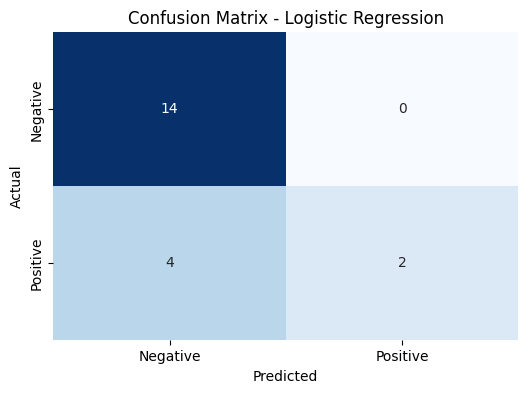

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_prostate, y_pred_prostate)

# Plot the confusion matrix using Seaborn heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


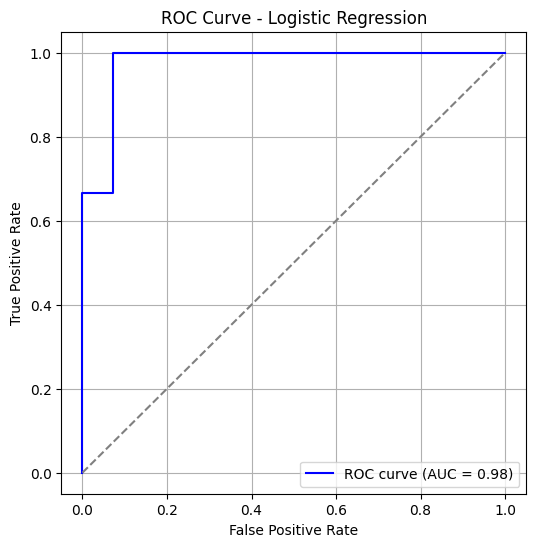

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Generar los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_prostate, y_pred_proba_prostate)

# Calcular el AUC
auc_roc = roc_auc_score(y_test_prostate, y_pred_proba_prostate)

# Graficar la curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea diagonal para referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
